# One Pixel Attack for Fooling Deep Neural Networks
An implementation of the procedure described in https://arxiv.org/abs/1710.08864.

## Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pathlib import Path
from tensorboardX import SummaryWriter
from torchvision import datasets, transforms, models
from tqdm import tqdm

from vgg import VGG

writer = SummaryWriter()
sns.set()
sns.set_style("dark")
sns.set_palette("muted")
sns.set_color_codes("muted")

In [44]:
import pandas as pd

### CUDA

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LOADER_KWARGS = {'num_workers': 1, 'pin_memory': True} if torch.cuda.is_available() else {'num_workers': 4}
print("CUDA Available:", torch.cuda.is_available())

CUDA Available: True


## Train CIFAR VGG16 Model

### Model Definition

In [12]:
from statistics import mode

# Vgg_16 = models.vgg16(pretrained=True)
Vgg_16 = VGG("VGG16")
Vgg_16.classifier = nn.Sequential(
        nn.Linear(512, 2048),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(2048, 2048),
        nn.ReLU(True),
        nn.Dropout(),
        nn.Linear(2048, 10),
    )
print(Vgg_16)
Vgg_16 = Vgg_16.to(DEVICE)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [27]:
WEIGHTS_PATH = Path("./vgg_cifar_weights2.pt")
Vgg_16.load_state_dict(torch.load(WEIGHTS_PATH))
Vgg_16 = Vgg_16.to(DEVICE)

In [14]:
print(Vgg_16.state_dict())

OrderedDict([('features.0.weight', tensor([[[[-0.1776, -0.0576,  0.1490],
          [-0.1892,  0.1461,  0.0509],
          [-0.1335,  0.0736, -0.1805]],

         [[ 0.0327, -0.0708,  0.0566],
          [ 0.1214,  0.0138,  0.0507],
          [ 0.1464,  0.0269,  0.1096]],

         [[-0.1121,  0.0218,  0.1573],
          [ 0.0337,  0.0832,  0.0138],
          [-0.0011,  0.1299,  0.1538]]],


        [[[ 0.0892, -0.0518,  0.1791],
          [-0.0681, -0.1696,  0.0976],
          [-0.1317, -0.1074,  0.0242]],

         [[ 0.1724, -0.0625,  0.0964],
          [-0.0840, -0.0271, -0.0142],
          [-0.0401, -0.1058, -0.1679]],

         [[ 0.1367, -0.0618,  0.0163],
          [ 0.0472, -0.0884, -0.0986],
          [ 0.0253,  0.0847,  0.1446]]],


        [[[ 0.0932,  0.0486, -0.1863],
          [-0.0868,  0.1038, -0.1408],
          [-0.0175, -0.0095,  0.0346]],

         [[ 0.0757, -0.0571, -0.1395],
          [-0.0554,  0.1178, -0.0962],
          [-0.1445,  0.0061,  0.1661]],

         

### Dataloading

In [15]:
BATCH_SIZE = 128
TRAIN_COUNT = 40_000
VAL_COUNT = 10_000
TEST_COUNT = 10_000

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.ToTensor()

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set = torch.utils.data.dataset.Subset(train_set, range(0,TRAIN_COUNT))
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, **LOADER_KWARGS)

val_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=test_transform)
val_set = torch.utils.data.dataset.Subset(val_set, range(TRAIN_COUNT,TRAIN_COUNT+VAL_COUNT))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, **LOADER_KWARGS)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Test and Validation Function

In [16]:
def test(epoch=None, is_validation=False):
    Vgg_16.eval()
    loader = val_loader if is_validation else test_loader
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = Vgg_16(inputs)
            test_loss += F.cross_entropy(outputs, targets, size_average=False).item()
            test_correct += outputs.max(1)[1].eq(targets).sum().item()
    if is_validation:
        writer.add_scalar('logs/val_loss', test_loss/len(loader.dataset), epoch)
        writer.add_scalar('logs/val_acc', test_correct/len(loader.dataset), epoch)
    else:
        print("Test Accuracy: {}/{}".format(test_correct, len(loader.dataset)))

### Train Function

In [23]:
#optimizer = optim.Adam(Vgg_16.classifier.parameters())
# 使用Adam进行优化处理
optimizer = torch.optim.Adam(Vgg_16.parameters())

train_losses = []
train_acc = []

# Training
def train(epoch):
    Vgg_16.train()
    epoch_loss = 0
    epoch_correct = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        optimizer.zero_grad()
        outputs = Vgg_16(inputs)
        loss = F.cross_entropy(outputs, targets)
        loss.backward()
        optimizer.step()
        batch_correct = outputs.max(1)[1].eq(targets).sum().item()
        epoch_loss += loss.item()
        epoch_correct += batch_correct
        writer.add_scalar('logs/train_loss', loss.item(), epoch*len(train_loader) + batch_idx)
        writer.add_scalar('logs/train_acc', batch_correct / targets.size(0), epoch*len(train_loader) + batch_idx)
        train_losses.append(loss)
        train_acc.append(batch_correct / targets.size(0))
    print("loss:{} -- and acc:{}".format(epoch_loss, epoch_correct))
    test(epoch, is_validation=True)

### Train Model and Store Weights (or Load Weights)

In [28]:
TRAIN_EPOCHS = 20

WEIGHTS_PATH = Path("./vgg_cifar_weights.pt")
for epoch in range(TRAIN_EPOCHS):
    train(epoch)
torch.save(Vgg_16.state_dict(), WEIGHTS_PATH)

100%|██████████| 313/313 [00:33<00:00,  9.27it/s]


loss:52.04098489135504 -- and acc:37927


d:\ANACONDA\envs\newtorch\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
100%|██████████| 313/313 [00:33<00:00,  9.25it/s]


loss:49.41108351573348 -- and acc:38062


100%|██████████| 313/313 [00:33<00:00,  9.24it/s]


loss:66.89680368453264 -- and acc:37474


100%|██████████| 313/313 [00:33<00:00,  9.21it/s]


loss:38.19440618902445 -- and acc:38497


100%|██████████| 313/313 [00:34<00:00,  9.20it/s]


loss:38.20749715715647 -- and acc:38519


100%|██████████| 313/313 [00:34<00:00,  9.20it/s]


loss:38.12591524422169 -- and acc:38504


100%|██████████| 313/313 [00:34<00:00,  9.21it/s]


loss:34.03901299741119 -- and acc:38657


100%|██████████| 313/313 [00:33<00:00,  9.22it/s]


loss:31.520724900066853 -- and acc:38813


100%|██████████| 313/313 [00:34<00:00,  9.20it/s]


loss:29.84381080698222 -- and acc:38819


100%|██████████| 313/313 [00:34<00:00,  9.20it/s]


loss:30.355460450053215 -- and acc:38863


100%|██████████| 313/313 [00:34<00:00,  9.19it/s]


loss:26.376627170480788 -- and acc:38989


100%|██████████| 313/313 [00:34<00:00,  9.16it/s]


loss:27.417857956606895 -- and acc:38970


100%|██████████| 313/313 [00:34<00:00,  9.19it/s]


loss:26.52467815577984 -- and acc:38970


100%|██████████| 313/313 [00:33<00:00,  9.22it/s]


loss:26.3603364569135 -- and acc:38986


100%|██████████| 313/313 [00:34<00:00,  9.18it/s]


loss:36.41640705615282 -- and acc:38641


100%|██████████| 313/313 [00:33<00:00,  9.21it/s]


loss:20.627266166266054 -- and acc:39214


100%|██████████| 313/313 [00:34<00:00,  9.20it/s]


loss:19.62254558922723 -- and acc:39267


100%|██████████| 313/313 [00:33<00:00,  9.21it/s]


loss:18.318229103460908 -- and acc:39319


100%|██████████| 313/313 [00:34<00:00,  9.20it/s]


loss:19.915107749868184 -- and acc:39260


100%|██████████| 313/313 [00:33<00:00,  9.21it/s]


loss:21.166405553929508 -- and acc:39234


In [ ]:
TRAIN_EPOCHS = 20
WEIGHTS_PATH = Path("./vgg_cifar_weights.pt")

if WEIGHTS_PATH.is_file():
    Vgg_16.load_state_dict(torch.load(WEIGHTS_PATH))
    print("Loaded weights from file:", WEIGHTS_PATH)
else:
    for epoch in range(TRAIN_EPOCHS):
        train(epoch)
    torch.save(Vgg_16.state_dict(), WEIGHTS_PATH)

In [17]:
print(Vgg_16.state_dict())

OrderedDict([('features.0.weight', tensor([[[[-5.5373e-01,  1.4270e-01,  5.2896e-01],
          [-5.8312e-01,  3.5655e-01,  7.6566e-01],
          [-6.9022e-01, -4.8019e-02,  4.8409e-01]],

         [[ 1.7548e-01,  9.8630e-03, -8.1413e-02],
          [ 4.4089e-02, -7.0323e-02, -2.6035e-01],
          [ 1.3239e-01, -1.7279e-01, -1.3226e-01]],

         [[ 3.1303e-01, -1.6591e-01, -4.2752e-01],
          [ 4.7519e-01, -8.2677e-02, -4.8700e-01],
          [ 6.3203e-01,  1.9308e-02, -2.7753e-01]]],


        [[[ 2.3254e-01,  1.2666e-01,  1.8605e-01],
          [-4.2805e-01, -2.4349e-01,  2.4628e-01],
          [-2.5066e-01,  1.4177e-01, -5.4864e-03]],

         [[-1.4076e-01, -2.1903e-01,  1.5041e-01],
          [-8.4127e-01, -3.5176e-01,  5.6398e-01],
          [-2.4194e-01,  5.1928e-01,  5.3915e-01]],

         [[-3.1432e-01, -3.7048e-01, -1.3094e-01],
          [-4.7144e-01, -1.5503e-01,  3.4589e-01],
          [ 5.4384e-02,  5.8683e-01,  4.9580e-01]]],


        [[[ 1.7715e-01,  5.2149

### Test Model Accuracy

In [30]:
test()

Test Accuracy: 8663/10000


In [29]:
WEIGHTS_PATH2 = Path("./vgg_cifar_weights_final.pt")
torch.save(Vgg_16.state_dict(), WEIGHTS_PATH2)

## Attack CIFAR Model

In [31]:
CIFAR_LABELS = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def show(img):
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

def tell(img, label, model, target_label=None):
    print("True Label:", CIFAR_LABELS[label], label)
    print("Prediction:", CIFAR_LABELS[model(img.unsqueeze(0)).max(-1)[1]], model(img.unsqueeze(0)).max(-1)[1][0].item())
    print("Label Probabilities:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0))
    print("True Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    if target_label is not None:
        print("Target Label Probability:", F.softmax(model(img.unsqueeze(0)).squeeze(), dim=0)[target_label].item())

### Prediction

True Label: deer 4
Prediction: deer 4
Label Probabilities: tensor([2.2723e-05, 9.7824e-07, 1.4295e-04, 4.9338e-05, 9.9943e-01, 4.9972e-06,
        9.5518e-05, 2.4631e-04, 7.0461e-07, 4.7161e-06], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.9994316697120667


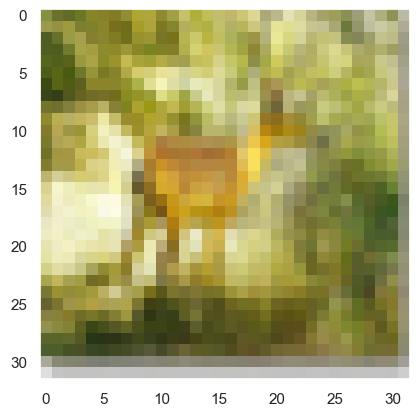

In [32]:
test_img, test_label = test_set[500]
test_img = test_img.to(DEVICE)
show(test_img)
tell(test_img, test_label, Vgg_16)

### Perturbation 扰动

Perturbation: [0.6  0.6  0.   0.   0.75]
True Label: deer 4
Prediction: deer 4
Label Probabilities: tensor([6.4147e-06, 1.6558e-07, 5.8637e-05, 6.7330e-06, 9.9980e-01, 1.0922e-06,
        1.7750e-05, 1.0818e-04, 1.2884e-07, 8.6042e-07], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.9998000264167786


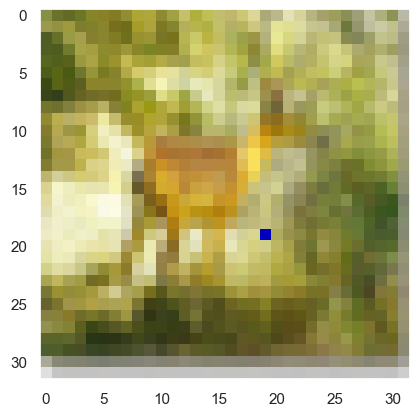

In [33]:
#对原始图片添加扰动p
def perturb(p, img):
    # Elements of p should be in range [0,1] 像素值必须在01之间
    # 5个值 x和y的坐标 + rgb的像素值
    img_size = img.size(1) # C x _H_ x W, assume H == W
    p_img = img.clone()
    xy = (p[0:2].copy() * img_size).astype(int)
    xy = np.clip(xy, 0, img_size-1)
    rgb = p[2:5].copy()
    rgb = np.clip(rgb, 0, 1)
    p_img[:,xy[0],xy[1]] = torch.from_numpy(rgb)
    return p_img

# 扰动p和原始图像加入原始图形并显示概率
def visualize_perturbation(p, img, label, model, target_label=None):
    p_img = perturb(p, img)
    print("Perturbation:", p)
    show(p_img)
    tell(p_img, label, model, target_label)

visualize_perturbation(np.array([0.6,0.6,0,0,0.75]), test_img, test_label, Vgg_16)

### Untargeted and Targeted Attacks

In [46]:
# 评估函数,返回
def evaluate(candidates, img, label, model):
    # print("in evaluate")
    preds = []
    model.eval()
    with torch.no_grad():
        for i, xs in enumerate(candidates):
            p_img = perturb(xs, img)
            preds.append(F.softmax(model(p_img.unsqueeze(0)).squeeze(), dim=0)[label].item())
    # print("preds={}".format(preds))
    # print("out evaluate")
    return np.array(preds)
#演化，返回一个新的候选集
def evolve(candidates, F=0.5, strategy="clip"):
    gen2 = candidates.copy()
    num_candidates = len(candidates)
    for i in range(num_candidates):
        #不重复地从400个候选集当中抽取3个，3个按照DE算法演进下一代,
        # 从0~400中随机选择3个数组成一维数组
        x1, x2, x3 = candidates[np.random.choice(num_candidates, 3, replace=False)]
        x_next = (x1 + F*(x2 - x3))
        if strategy == "clip":
            gen2[i] = np.clip(x_next, 0, 1)
        elif strategy == "resample":
            x_oob = np.logical_or((x_next < 0), (1 < x_next))
            x_next[x_oob] = np.random.random(5)[x_oob]
            gen2[i] = x_next
    return gen2

def attack(model, img, true_label, target_label=None, iters=100, pop_size=400, verbose=True):
    # Targeted: maximize target_label if given (early stop > 50%)
    #目标攻击：最大化目标标签的值，当目标标签的概率大于50%时可以提前结束
    # Untargeted: minimize true_label otherwise (early stop < 5%) 
    # 无目标攻击的要求，最小化真实标签，当真实标签概率小于5%时可以提前结束

    #400个候选解
    candidates = np.random.random((pop_size,5))

    #作用后两列中的元素，该函数的作用是将数组a中的所有数限定到范围a_min和a_max中。
    candidates[:,2:5] = np.clip(np.random.normal(0.5, 0.5, (pop_size, 3)), 0, 1)
    print("candidates={}".format(candidates))
    print("---------------------------------")
    #是否是有目标攻击
    is_targeted = target_label is not None   
    label = target_label if is_targeted else true_label
    fitness = evaluate(candidates, img, label, model)
    
    def is_success():
        return (is_targeted and fitness.max() > 0.5) or ((not is_targeted) and fitness.min() < 0.05)
    
    for iteration in range(iters):     #de100次
        # Early Stopping
        if is_success():
            break
        if verbose and iteration%10 == 0: # Print progress 10次输出一下
            print("Target Probability [Iteration {}]:".format(iteration), fitness.max() if is_targeted else fitness.min())
        # Generate new candidate solutions 生成一个新的候选集
        new_gen_candidates = evolve(candidates, strategy="resample")
        # print("new_gen_candidates={}".format(new_gen_candidates))
        # Evaluate new solutions  评估新的候选集
        new_gen_fitness = evaluate(new_gen_candidates, img, label, model)
        # print("new_gen_fitness={}".format(new_gen_fitness))
        # Replace old solutions with new ones where they are better  替换当中下一代更加优秀的候选
        successors = new_gen_fitness > fitness if is_targeted else new_gen_fitness < fitness
        # print("successors={}".format(successors))
        candidates[successors] = new_gen_candidates[successors]
        fitness[successors] = new_gen_fitness[successors]
    best_idx = fitness.argmax() if is_targeted else fitness.argmin()
    best_solution = candidates[best_idx]
    best_score = fitness[best_idx]
    if verbose:
        visualize_perturbation(best_solution, img, true_label, model, target_label)
    return is_success(), best_solution, best_score

# Untargeted attack 无目标攻击
# _ = attack(Vgg_16, test_img, test_label, iters=200)

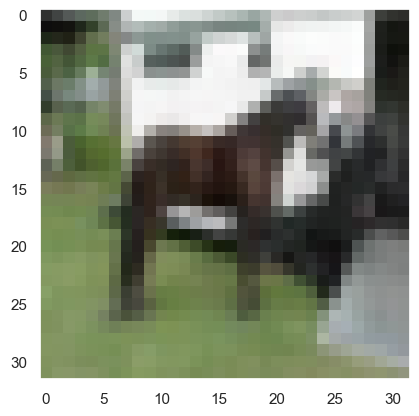

In [35]:
test_img, test_label = test_set[20]
test_img = test_img.to(DEVICE)
show(test_img)

candidates=[[0.10158371 0.27187773 0.47755627 0.         0.01589937]
 [0.66043705 0.36254979 0.36621845 0.45961916 0.27706577]
 [0.40831929 0.87081664 0.42898822 0.46273463 0.83207865]
 ...
 [0.54245834 0.39733586 0.34063067 1.         0.69570308]
 [0.7190395  0.37499529 0.70582266 1.         0.82013666]
 [0.06531886 0.11142075 0.         1.         1.        ]]
---------------------------------
in evaluate
preds=[0.965667188167572, 0.954208254814148, 0.9782211184501648, 0.9686750769615173, 0.9843445420265198, 0.9880771636962891, 0.9746637344360352, 0.9642244577407837, 0.9921075701713562, 0.9781802892684937, 0.9808165431022644, 0.995408833026886, 0.9933843016624451, 0.9884196519851685, 0.9687144756317139, 0.9810878038406372, 0.9895772933959961, 0.9687725305557251, 0.9778865575790405, 0.9891412258148193, 0.9715940356254578, 0.9644419550895691, 0.9856616854667664, 0.9602187275886536, 0.902391791343689, 0.9896745085716248, 0.987080991268158, 0.9535702466964722, 0.9664163589477539, 0.97641

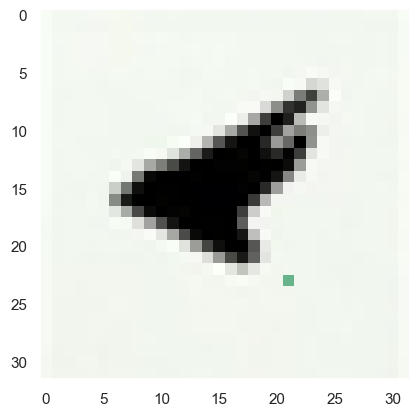

In [47]:
import pandas as pd
pd.set_option('display.width', 1000)  # 设置字符显示宽度
pd.set_option('display.max_rows', None)  # 设置显示最大


# Untargeted attack 无目标攻击
_ = attack(Vgg_16, test_img, test_label, iters=1)

## 目标攻击

True Label: airplane 0
Prediction: airplane 0
Label Probabilities: tensor([9.6968e-01, 2.2364e-05, 2.9048e-02, 2.5439e-04, 3.1075e-05, 7.7777e-06,
        5.6762e-05, 1.7382e-05, 8.6789e-04, 1.6662e-05], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.9696774482727051


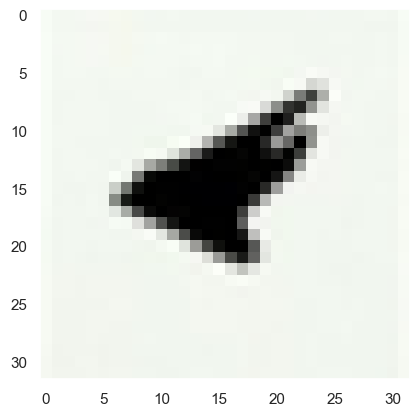

In [39]:
test_img, test_label = test_set[21]
test_img = test_img.to(DEVICE)
show(test_img)
tell(test_img, test_label, Vgg_16)

Target Probability [Iteration 0]: 0.03545651584863663
Target Probability [Iteration 10]: 0.19530683755874634
Target Probability [Iteration 20]: 0.4390106499195099
Target Probability [Iteration 30]: 0.48071038722991943
Perturbation: [0.42650164 0.52256526 0.95443895 0.97650768 0.72629652]
True Label: airplane 0
Prediction: cat 3
Label Probabilities: tensor([0.4392, 0.0062, 0.0189, 0.5088, 0.0008, 0.0084, 0.0030, 0.0031, 0.0057,
        0.0060], device='cuda:0', grad_fn=<SoftmaxBackward0>)
True Label Probability: 0.43917787075042725
Target Label Probability: 0.5088200569152832


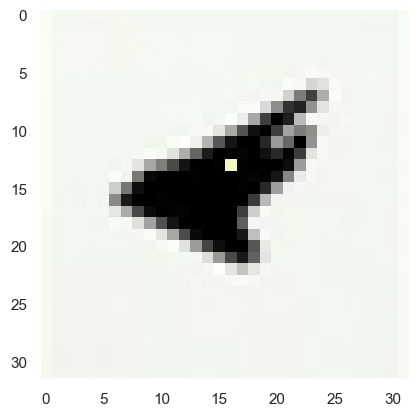

In [40]:
# targeted attack 目标攻击
_ = attack(Vgg_16, test_img, test_label, iters=200, target_label= 3)

In [37]:
# Targeted attack
# This is much harder/costlier than an untargeted attack
# For time reasons, targeted attacks below use 20 iterations
targeted_results = {3}
for idx in range(len(CIFAR_LABELS)):
    if idx != test_label:
        targeted_results[idx] = attack(Vgg_16, test_img, test_label, target_label=idx, iters=20, verbose=False)
        print(CIFAR_LABELS[idx], idx, targeted_results[idx][0], targeted_results[idx][2])
    else:
        print(CIFAR_LABELS[idx], idx, "True Label")

TypeError: 'set' object does not support item assignment

In [ ]:
%load_ext watermark
%watermark --updated --datename --python --machine --watermark -p torch,numpy,matplotlib,tensorboardX,torchvision,seaborn,tqdm